## Installation
pyMOR can be installed easily via pip:

In [1]:
!pip install --upgrade pip
!pip install numpy scipy cython matplotlib
!pip install git+https://github.com/pymor/pymor@ngs-user-meeting17

Requirement already up-to-date: pip in /home/stephan/.virtualenvs/ngsmeeting/lib/python3.4/site-packages
  Cloning https://github.com/pymor/pymor (to ngs-user-meeting17) to /tmp/pip-01osx2tn-build


In [2]:
%matplotlib notebook
import netgen.gui
%gui tk

## Thermal Block Problem

The problem is to solve the stationary heat diffusion problem
$$\int_\Omega d_\mu(x) \nabla u(x) \cdot \nabla v(x) dx = \int_\Omega v(x) dx \qquad v \in H^1_0(\Omega)$$
for $u \in H^1_0(\Omega)$, where $d_\mu(x)$ has the form
$$d_\mu(x) = \sum_{q=1}^Q \mu_q \cdot \chi_{\Omega_q}(x),$$
assuming that $\Omega = \bigcup_{q=1}^Q \Omega_q$.  

Thus, with
$$b_q(u, v) := \int_{\Omega_q} \nabla u(x) \cdot \nabla v(x) dx, \quad q = 1, \ldots Q, \qquad l(v):= \int_{\Omega} v(x) dx,$$
the problem is of the form
$$\sum_{q=1}^Q \mu_q\cdot b_q(u, v) = l(v) \qquad v \in H^1_0(\Omega).$$
This is called an **affine parametric decomposition** and easily enables efficient **online assembly** of the reduced system matrix for given $\mu$.

## Discretization with NGSovle

We assume
$$\Omega = [-1, 1]^3,$$
which is decomposed into $2 \times 2 \times 2$ equal sized sub-cubes:

In [3]:
import numpy as np
from ngsolve import *
from netgen.csg import *

geo = CSGeometry()
obox = OrthoBrick(Pnt(-1, -1, -1), Pnt(1, 1, 1)).bc("outer")

b = [OrthoBrick(Pnt(-1, -1, -1), Pnt(0.0, 0.0, 0.0)),
     OrthoBrick(Pnt(-1,  0, -1), Pnt(0.0, 1.0, 0.0)),
     OrthoBrick(Pnt(0,  -1, -1), Pnt(1.0, 0.0, 0.0)),
     OrthoBrick(Pnt(0,   0, -1), Pnt(1.0, 1.0, 0.0)),
     OrthoBrick(Pnt(-1, -1,  0), Pnt(0.0, 0.0, 1.0)),
     OrthoBrick(Pnt(-1,  0,  0), Pnt(0.0, 1.0, 1.0)),
     OrthoBrick(Pnt(0,  -1,  0), Pnt(1.0, 0.0, 1.0)),
     OrthoBrick(Pnt(0,   0,  0), Pnt(1.0, 1.0, 1.0))]
box = (obox - b[0] - b[1] - b[2] - b[3] - b[4] - b[5] - b[6] - b[7])

geo.Add(box)
for bi in b:
    geo.Add(bi)
# domain 0 is empty!

We now assemble the matrices of $b_q$ and $l$. To reduce the complexity of the problem, we assign the same heat conductivity to diagonally opposite sub-blocks of the domain:

In [4]:
mesh = Mesh(geo.GenerateMesh(maxh=0.3))

V = H1(mesh, order=4, dirichlet="outer")
v = V.TestFunction()
u = V.TrialFunction()

with TaskManager():
    # the right hand side l
    f = LinearForm(V)
    f += SymbolicLFI(1 * v)
    f.Assemble()
    gf_f = GridFunction(V)
    gf_f.vec.data = f.vec

    # the bilinear forms b_q
    mats = []
    coeffs = [[0, 1, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 1, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 1, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0]]
    for c in coeffs:
        diffusion = CoefficientFunction(c)
        a = BilinearForm(V, symmetric=False)
        a += SymbolicBFI(diffusion * grad(u) * grad(v),
                         definedon=(np.where(np.array(c) == 1)[0] + 1).tolist())
        a.Assemble()
        mats.append(a.mat)

## pyMOR wrapping

To make the assembled matrices available to pyMOR, we have to wrap them using `NGSolveMatrixOperator`, which satisfies pyMOR's `OperatorInterface`. In order to encode the affine decomposition of the system matrix, we form a `LincombOperator` of the wrapped matrices with appropriate `ParameterFunctionals` as coefficients:

In [5]:
from pymor.basic import *
from pymor.bindings.ngsolve import *

space = NGSolveVectorSpace(V)
op = LincombOperator(
        [NGSolveMatrixOperator(m, space, space) for m in mats],
        [ProjectionParameterFunctional('diffusion', (len(coeffs),), (i,))
         for i in range(len(coeffs))]
     )

h1_0_op = op.assemble([1., 1., 1., 1.])

F = VectorFunctional(op.range.make_array([gf_f]))

d = StationaryDiscretization(
        op, F, 
        visualizer=NGSolveVisualizer(mesh, V),
        products={'h1_0_semi': h1_0_op},
        parameter_space=CubicParameterSpace(op.parameter_type, 0.1, 1.)
)

## An now some MOR!

We can easily solve the problem for a given $\mu$ and visualize the solution:

In [6]:
U = d.solve([1., 0.1, 0.1, 0.1])
d.visualize(U)

00:00 StationaryDiscretization: Solving StationaryDiscretization for {diffusion: [1.0, 0.1, 0.1, 0.1]} ...


But now, let us compute a reduced order model. In order to do so, we first need to specify a `reductor` which implements the reduced basis projection (and error estimator assembly):

In [7]:
reductor = CoerciveRBReductor(
    d, 
    product=d.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)',
                                                       d.parameter_type)
)

Then we can run the `greedy` algorithm to generate a reduced basis and the corresponding reduced order model:

In [8]:
greedy_data = greedy(
    d, reductor, d.parameter_space.sample_uniformly(3),
    extension_params={'method': 'gram_schmidt'},
    max_extensions=20
)
rd = greedy_data['reduced_discretization']

00:00 greedy: Started greedy search on 81 samples
00:00 greedy: Reducing ...
00:00 |   CoerciveRBReductor: RB projection ...
00:00 |   CoerciveRBReductor: Assembling error estimator ...
00:00 |   |   ResidualReductor: Estimating residual range ...
00:00 |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
00:01 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:01 |   |   ResidualReductor: Projecting residual operator ...
00:01 greedy: Estimating errors ...
00:01 greedy: Maximum error after 0 extensions: 8.033589924625625 (mu = {diffusion: [0.1, 0.1, 0.1, 0.1]})
00:01 greedy: Computing solution snapshot for mu = {diffusion: [0.1, 0.1, 0.1, 0.1]} ...
00:01 |   StationaryDiscretization: Solving StationaryDiscretization for {diffusion: [0.1, 0.1, 0.1, 0.1]} ...
00:02 greedy: Extending basis with solution snapshot ...
      
00:02 greedy: Reducing ...
00:02 |   CoerciveRBReductor: RB projection ...
00:02 |   CoerciveRBReductor: Assembling error es

00:12 |   |   |   |   gram_schmidt: Removing linear dependent vector 26
00:12 |   |   ResidualReductor: Projecting residual operator ...
00:12 greedy: Estimating errors ...
00:12 greedy: Maximum error after 8 extensions: 3.9819685397026103 (mu = {diffusion: [0.1, 1.0, 1.0, 0.1]})
00:12 greedy: Computing solution snapshot for mu = {diffusion: [0.1, 1.0, 1.0, 0.1]} ...
00:12 |   StationaryDiscretization: Solving StationaryDiscretization for {diffusion: [0.1, 1.0, 1.0, 0.1]} ...
00:13 greedy: Extending basis with solution snapshot ...
      
00:13 greedy: Reducing ...
00:13 |   CoerciveRBReductor: RB projection ...
00:13 |   CoerciveRBReductor: Assembling error estimator ...
00:13 |   |   ResidualReductor: Estimating residual range ...
00:13 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 8 ...
00:13 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:14 |   |   |   |   gram_schmidt: Orthonormalizing vector 26 again
00:14 |   |   |   |   gram_schmid

00:27 greedy: Extending basis with solution snapshot ...
00:27 |   gram_schmidt: Orthonormalizing vector 15 again
      
00:27 greedy: Reducing ...
00:27 |   CoerciveRBReductor: RB projection ...
00:27 |   CoerciveRBReductor: Assembling error estimator ...
00:27 |   |   ResidualReductor: Estimating residual range ...
00:27 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 15 ...
00:28 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:28 |   |   |   |   gram_schmidt: Orthonormalizing vector 55 again
00:28 |   |   |   |   gram_schmidt: Orthonormalizing vector 56 again
00:29 |   |   ResidualReductor: Projecting residual operator ...
00:29 greedy: Estimating errors ...
00:29 greedy: Maximum error after 16 extensions: 0.08866787691593353 (mu = {diffusion: [1.0, 0.1, 0.55, 0.1]})
00:29 greedy: Computing solution snapshot for mu = {diffusion: [1.0, 0.1, 0.55, 0.1]} ...
00:29 |   StationaryDiscretization: Solving StationaryDiscretization for {diffusion: 

Using the reduced order model, we can quickly compute the parameter to output mapping:

CPU times: user 2.64 s, sys: 1.83 s, total: 4.47 s
Wall time: 2.3 s


<IPython.core.display.Javascript object>


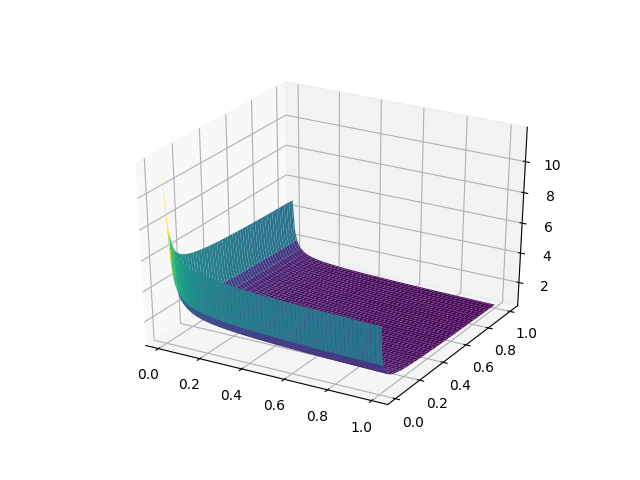

In [9]:
X = Y = np.linspace(0.01, 1, 100)
X, Y = np.meshgrid(X, Y)

def param_to_output_mapping(mu1, mu2):
    return rd.rhs.apply(rd.solve([mu1, mu2, 1, 1.])).data[0]
param_to_output_mapping = np.vectorize(param_to_output_mapping)

%time Z = param_to_output_mapping(X, Y)

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.gca(projection='3d').plot_surface(X, Y, Z, cmap=cm.viridis)

We also have a **rigorous error estimator** which guarantees the reliability of the reduced order model:

In [10]:
def param_to_error_mapping(mu1, mu2):
    mu = [mu1, mu2, 1., 1.]
    u = rd.solve(mu)
    return rd.estimate(u, mu) / rd.h1_0_semi_norm(u)[0]
param_to_error_mapping = np.vectorize(param_to_error_mapping)

np.max(param_to_error_mapping(X, Y))

0.078879588977261508

Using the `reductor`, we can also reconstruct a high-dimensional state from solutions of the reduced order model:

In [11]:
mu = d.parameter_space.sample_randomly(1)[0]
U = d.solve(mu)
u = rd.solve(mu)
d.visualize(U - reductor.reconstruct(u))

00:57 StationaryDiscretization: Solving StationaryDiscretization for {diffusion: [0.4370861069626263, 0.9556428757689246, 0.7587945476302645, 0.6387926357773329]} ...


Finally, we can save the reduced order model to disk for later use. No access to NGSolve is required to use it again:

In [12]:
from pymor.core.pickle import dump
dump(rd, open('reduced_model.out', 'wb'))